In [6]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pathlib import Path
import json
from torch.utils.data import DataLoader
from models import MLP, CombinedModel, ResNet
from datasets_loaders import TaijiDataset
from torchvision import transforms

In [7]:
# Load the saved model
def load_model(model_path, params_path):
    with open(params_path, "r") as f:
        params = json.load(f)
    
    resnet_feature_extractor = ResNet()
    mocap_model = MLP(params["mlp_mocap"]["input_dim"], params["mlp_mocap"]["h1"], params["mlp_mocap"]["h2"], params["mlp_mocap"]["output_dim"])
    footp_model = MLP(params["mlp_footp"]["input_dim"], params["mlp_footp"]["h1"], params["mlp_footp"]["h2"], params["mlp_footp"]["output_dim"])

    combined_model = CombinedModel(resnet_feature_extractor, mocap_model, params["mlp_mocap"]["output_dim"],
                                   footp_model, params["mlp_footp"]["output_dim"], params["combined_model"]["num_classes"])
    combined_model.load_state_dict(torch.load(model_path))
    return combined_model

In [ ]:
# Function to extract softmax inputs
def extract_softmax_inputs(model, dataloader, device):
    softmax_inputs = []
    true_labels = []

    with torch.no_grad():
        for image_input, mocap_input, footp_input, labels in dataloader:
            image_input = image_input.to(device)
            mocap_input = mocap_input.to(device)
            footp_input = footp_input.to(device)
            labels = labels.to(device)

            # Forward pass to get softmax inputs
            model.eval()
            x = model.resnet_feature_extractor(image_input)
            x = x.view(x.size(0), -1)
            if model.mlp_mocap is not None:
                mocap_input = model.mlp_mocap(mocap_input)
                x = torch.cat((x, mocap_input), dim=1)
            if model.mlp_footp is not None:
                footp_input = model.mlp_footp(footp_input)
                x = torch.cat((x, footp_input), dim=1)

            x = F.relu(model.bn1(model.fc1(x)))
            x = F.relu(model.bn2(model.fc2(x)))
            x = model.bn3(model.fc3(x))

            softmax_inputs.append(x.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    softmax_inputs = np.vstack(softmax_inputs)
    true_labels = np.array(true_labels)

    return softmax_inputs, true_labels

In [ ]:
# Compute the t-SNE plot
def compute_tsne(softmax_inputs, n_components=2, perplexity=30, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(softmax_inputs)
    return tsne_results

# Visualize the t-SNE plot
def visualize_tsne(tsne_results, true_labels,num_classes,save_folder):
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap=plt.cm.get_cmap("jet", num_classes), marker='o', s=50)
    plt.colorbar(ticks=range(num_classes))
    plt.clim(-0.5, num_classes - 0.5)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Softmax Inputs")
    plt.savefig(save_folder+"tsne_visualization_train_test.png")
    plt.show()

# def visualize_tsne(train_tsne_results, test_tsne_results, train_labels, test_labels):
#     num_classes = len(np.unique(train_labels))
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     for i in range(num_classes):
#         ax1.scatter(train_tsne_results[train_labels == i, 0], train_tsne_results[train_labels == i, 1], label=i, alpha=0.6, cmap=plt.cm.get_cmap("jet", num_classes))
#         ax2.scatter(test_tsne_results[test_labels == i, 0], test_tsne_results[test_labels == i, 1], label=i, alpha=0.6, cmap=plt.cm.get_cmap("jet", num_classes))

#     ax1.set_title("Train t-SNE Visualization")
#     ax2.set_title("Test t-SNE Visualization")
#     ax1.set_xlabel("t-SNE Component 1")
#     ax2.set_xlabel("t-SNE Component 1")
#     ax1.set_ylabel("t-SNE Component 2")
#     ax2.set_ylabel("t-SNE Component 2")

#     plt.legend(loc="best")
#     plt.savefig("tsne_visualization_train_test.png")
#     plt.show()

#---------------------------------------------
# Main function to load the model, extract softmax inputs, compute t-SNE and visualize the t-SNE plot

# def main(model_path, params_path, dataloader,device):
#     combined_model = load_model(model_path, params_path)
#     combined_model = combined_model.to(device)
#     softmax_inputs, true_labels = extract_softmax_inputs(combined_model, dataloader,device)
#     tsne_results = compute_tsne(softmax_inputs)
#     visualize_tsne(tsne_results, true_labels,num_classes=46)

def main(model_path, params_path, train_loader, test_loader, device,save_folder):
    combined_model = load_model(model_path, params_path)
    combined_model = combined_model.to(device)

    print("Extracting training logits from combined_model")
    train_softmax_inputs, train_labels = extract_softmax_inputs(combined_model, train_loader,device)
    print("Extracting test logits from combined_model")
    test_softmax_inputs, test_labels = extract_softmax_inputs(combined_model, test_loader,device)
    
    print("t-SNE fit transform for training data")
    tsne = TSNE(n_components=2, random_state=42)
    train_tsne_results = tsne.fit_transform(train_softmax_inputs)
    print("t-SNE fit transform for test data")
    tsne = TSNE(n_components=2, random_state=42)
    test_tsne_results = tsne.fit_transform(test_softmax_inputs)

    print("Generating t-SNE plot for train")
    visualize_tsne(train_tsne_results, train_labels, 46,save_folder+"train_")
    print("Generating t-SNE plot for test")
    visualize_tsne(test_tsne_results, test_labels, 46,save_folder+"test_")
    # visualize_tsne(train_tsne_results, test_tsne_results, train_labels, test_labels)

device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_root_dir = './dataset_100_per_pose'
batch_size = 32
# Example usage
for test_subj in range(1,11):
    test_subject = 'Subject'+str(test_subj)
    print("test_subject : ",test_subject)
    results_root_dir = "./runs/ten_subjs_run8_10_epochs/" + test_subject
    save_folder_ = results_root_dir+"/"
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    model_path = results_root_dir + "/combined_model.pth"
    params_path = results_root_dir + "/training_params.json"

    train_dataset = TaijiDataset(dataset_root_dir, transform=transform, test=False, test_subject=test_subject)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    test_dataset = TaijiDataset(dataset_root_dir, transform=transform, test=True, test_subject=test_subject)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    main(model_path, params_path, train_loader, test_loader,device_, save_folder_)

In [ ]:
# def extract_resnet_features(self, image_input):
#     resnet_features = self.resnet_feature_extractor(image_input)
#     return resnet_features

In [8]:
# results_root_dir = "./runs/ten_subjs_run8_10_epochs/" + test_subject
model_path_  = 'runs/ten_subjs_run8_10_epochs/Subject1/combined_model.pth'
params_path_ = 'runs/ten_subjs_run8_10_epochs/Subject1/training_params.json'
trained_model = load_model(model_path_, params_path_)

Using cache found in /home/paperspace/.cache/torch/hub/pytorch_vision_v0.10.0
/home/paperspace/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# trained_model.resnet_feature_extractor.feature_extractor[4]

In [10]:
# bb1 = trained_model.resnet_feature_extractor.feature_extractor[4][0]
# bb1

In [11]:
# bb1.conv1

In [12]:
# trained_model.resnet_feature_extractor.feature_extractor[1]

In [13]:
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def display_feature_maps(images, feature_maps, title):
    num_classes = len(images)
    
    for i in range(num_classes):
        fig, axs = plt.subplots(3, 3, figsize=(9, 9))
        
        # Show input image
        axs[0, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axs[0, 0].set_title(f"Class {i} Image", fontsize=10)
        axs[0, 0].axis("off")
        
        # Show first 8 feature maps
        for j in range(1,9):
            row = j // 3 #+ 1
            col = j % 3
            # print("----------")
            # print("row : ",row)
            # print("col : ",col)
            axs[row, col].imshow(feature_maps[i][j].detach().cpu(), cmap="viridis")
            axs[row, col].set_title(f"Feature Map {j+1}", fontsize=10)
            axs[row, col].axis("off")
            
        fig.suptitle(f"{title} for Class {i}", fontsize=14, y=0.93)
        plt.savefig(f"{title}_feature_maps_class_{i}.png", bbox_inches="tight")
        plt.show()

def visualize_resnet_feature_maps(model, layer_num, images, device):
    # Get the selected layer from the model
    layer = model.feature_extractor[layer_num]
    images = [img.to(device) for img in images]

    feature_maps = []
    for img in images:
        img = img.unsqueeze(0)  # Add batch dimension
        x = img
        for l in model.feature_extractor[:layer_num + 1]:
            # print("l : ",l)
            x = l(x)
        feature_maps.append(x[0])

    display_feature_maps(images, feature_maps, f"ResNet Feature Maps Layer {layer_num}")


In [48]:
from torchvision import transforms
from PIL import Image
import os
import glob

transform_ = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# for test_subj in range(1,11):
example_images = []
test_subject = 'Subject1'
print("test_subject : ",test_subject)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for pose in range(46):
    temp_dir = "./dataset_100_per_pose/Subject1/"+str(pose)+"/"
    img_path = glob.glob(temp_dir+"*.jpg")[0]
    image = Image.open(img_path)
    image = transform_(image).to(device)
    example_images.append(image)
# Load the pretrained ResNet-18 model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# resnet_model = ResNet().to(device)
# resnet_model.eval()

# Select the layer number from which to extract the feature maps
layer_num = 4  # Choose a layer number (e.g., 2 for the first convolutional layer)
trained_model = trained_model.to(device)
# Provide one image per class to visualize their feature maps
# (Assuming images are already loaded as PyTorch tensors, normalized and in the right shape)
# example_images = [image1, image2, image3, ..., image46]  # Replace with your images

visualize_resnet_feature_maps(trained_model.resnet_feature_extractor, layer_num, example_images, device)

In [50]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
# from models import CombinedModel

In [51]:
def plot_roc_and_pr_curves(y_true, y_probs, num_classes, results_root_dir):
    y_true_one_hot = np.eye(num_classes)[y_true]  # Convert ground truth to one-hot encoding

    # Plot ROC and PR curves for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curve for class {i}')
        plt.legend(loc="lower right")
        plt.savefig(results_root_dir + f'/roc_class_{i}.png')
        plt.close()

        precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_probs[:, i])
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall curve for class {i}')
        plt.savefig(results_root_dir + f'/pr_class_{i}.png')
        plt.close()


In [55]:
batch_size = 64
num_classes = 46
combined_model = trained_model
dataset_root_dir = './dataset_100_per_pose'
for test_subj in range(1,11):
    test_subject = 'Subject'+str(test_subj)
    print("test_subject :",test_subject)
    results_root_dir = "./runs/ten_subjs_run8_10_epochs/"+test_subject
    Path(results_root_dir).mkdir(parents=True, exist_ok=True)

    # train_dataset = TaijiDataset(dataset_root_dir, transform=transform, test=False, test_subject=test_subject)
    test_dataset = TaijiDataset(dataset_root_dir, transform=transform_, test=True, test_subject=test_subject)
    # print("len(train_dataset) :",len(train_dataset))
    # print("len(test_dataset) :",len(test_dataset))

    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    with torch.no_grad():
        test_probabilities = []
        test_true_labels = []
        for image_input, mocap_input, footp_input, labels in test_loader:
            image_input = image_input.to(device)
            mocap_input = mocap_input.to(device)
            footp_input = footp_input.to(device)
            labels = labels.to(device)

            outputs = combined_model(image_input, mocap_input, footp_input)
            probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
            test_probabilities.extend(probabilities.cpu().numpy())
            test_true_labels.extend(labels.detach().cpu().numpy())
        test_probabilities = np.array(test_probabilities)
        plot_roc_and_pr_curves(test_true_labels, test_probabilities, num_classes, results_root_dir)

test_subject : Subject1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def save_confusion_matrix(y_true, y_pred, class_names, output_file):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix using seaborn heatmap without numbers
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, cmap='coolwarm', xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Normalized Frequency'})
    
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    plt.savefig(output_file)
    plt.show()

In [7]:
import pandas as pd
pred_df = pd.read_csv("./runs/ten_subjs_run8_10_epochs/Subject2/test_predictions.csv")

In [8]:
pred_df

,true_labels,predicted_labels
0,18,18
1,18,18
2,18,18
3,18,14
4,18,18
...,...,...
4595,14,14
4596,14,14
4597,14,14
4598,14,14


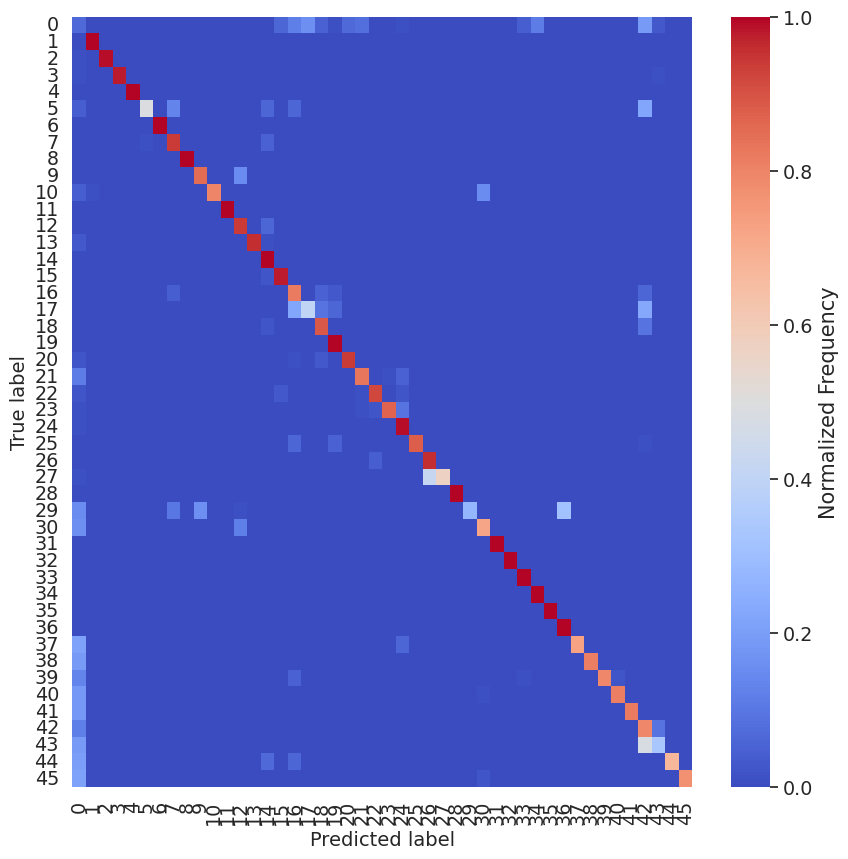

In [9]:
# Example usage
y_true = pred_df["true_labels"].tolist()
y_pred = pred_df["predicted_labels"].tolist()
class_names = [str(x) for x in range(46)]
output_file = './runs/ten_subjs_run8_10_epochs/Subject2/confusion_matrix.png'

save_confusion_matrix(y_true, y_pred, class_names, output_file)
